# Task 2

Cluster the meter readings r1 to r12 - justify the number of clusters and method used\
-- This exercise is to show your basic ML skills and understanding

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# file_path = '/content/drive/My Drive/cons_data_all_res.xlsx'
# data = pd.read_excel(file_path, parse_dates=['Time'])

In [3]:
# alternate way to load the dataset, make sure to keep the .xlsx file in the same directory as the notebook

file_path2 = 'cons_data_all_res.xlsx'
data = pd.read_excel(file_path2)

## Entire data

In [4]:
# extracting the relevant columns for clustering
X = data[['temp', 'humid']]
y_true = data['season']

# standardize the data by centering and scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

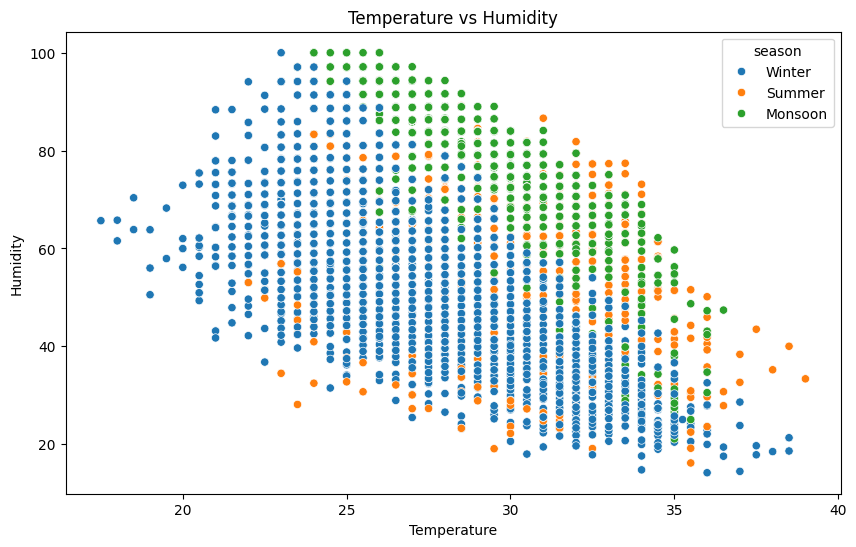

In [5]:
# scatterplot to visualize how temp and humidity affect season
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='temp', y='humid', hue='season') # we can also plot x=humid and y=temp, but that doesn't make any difference
plt.xlabel('Temperature')
plt.ylabel('Humidity')
plt.title('Temperature vs Humidity')
# plt.legend(title='Season') # not needed since sns automatically detects the legend
plt.show()

Winter and monsoon clusters are well-defined while summer clusters aren't very well-defined. Let's see if K-Means can identify the seasonal clusters.

In [6]:
# 3 clusters because there are 3 seasons in the dataset
num_clusters = 3

# setting up a K-Means model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

# adding cluster labels to the dataframe
data['Cluster'] = y_kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


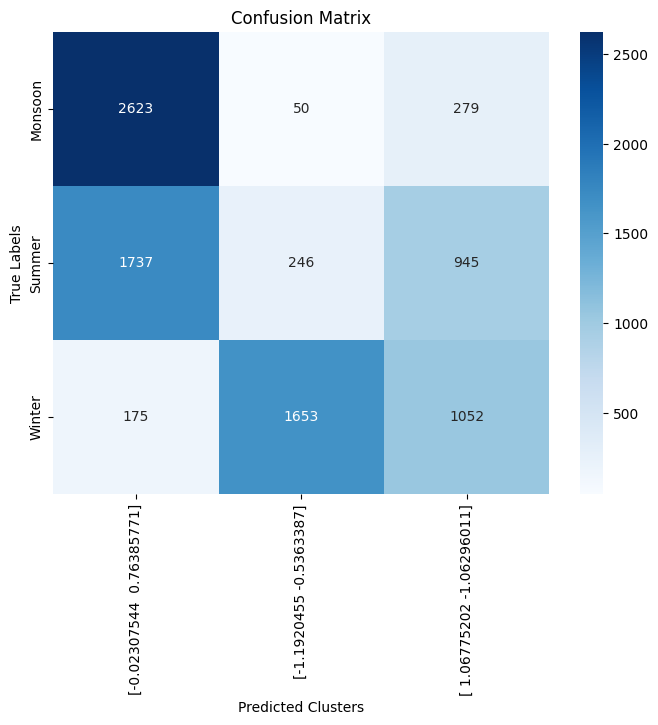

In [7]:
# y_true is converted from to a categorical data type
# each category is assigned a unique integer code starting from 0 for better plotting of the heatmap
y_true_numeric = y_true.astype('category').cat.codes

# create a confusion matrix to compare true labels with cluster labels
conf_matrix = confusion_matrix(y_true_numeric, y_kmeans)

# plotting the confusion matrix
plt.figure(figsize=(8, 6))
xticklabels = [str(center) for center in kmeans.cluster_centers_]  # convert cluster centers to strings
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=np.unique(y_true))
plt.xlabel('Predicted Clusters')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Clustering is an unsupervised learning method. Which is why the x-axis labels aren't "labelled". The algorithm identifies the cluster that a data point belongs to, it looks for patterns in the data.So it doesn't really replicate the existing labels (seasons) and assign those to the data points.

We can see that summer and winter have similar numbers in the heatmap in correlation with cluster labels 0 and 1 respectively. This can be attributed to a large overlap of summer and winter data points in the scatterplot.

In [8]:
# classification report for performance metrics of the clustering algorithm
print(classification_report(y_true_numeric, y_kmeans))

              precision    recall  f1-score   support

           0       0.58      0.89      0.70      2952
           1       0.13      0.08      0.10      2928
           2       0.46      0.37      0.41      2880

    accuracy                           0.45      8760
   macro avg       0.39      0.45      0.40      8760
weighted avg       0.39      0.45      0.40      8760



* Cluster 0 has relatively high precision and recall. K-Means did a good job identifying instances in this cluster.
* Cluster 1 has low precision and recall. K-Means struggled to correctly identify instances in this cluster.
* Cluster 2 has moderate precision and recall, K-Means had some level of difficulty identifying instances in this cluster but better than cluster 1.

In [9]:
# checking the clustering using inertia (the sum of squared distances from the cluster center)
print(f'Inertia: {kmeans.inertia_}')

# checking how similar a data point is to other objects of the same cluster using silhouette score
sil_score = silhouette_score(X_scaled, y_kmeans)
print(f'Silhouette Score: {sil_score}')

Inertia: 6375.470262860217
Silhouette Score: 0.451960632346559


* Lower the inertia value, the closer the data points are to the cluster center.
* It's hard to tell how compact the clusters are because there's no other inertia score to compare it to.
* Closer the silhouette score to 1, the more similar a data point is to the other objects in the same cluster.
* A silhouette score of 0.45 indicates a moderate level of clustering.

The above clustering was done for all the meters. We can do the same clustering for each energy meter. The clustering may or may not be more accurate, let's see how this pans out.


Since there are a lot of meters and it would be cumbersome to create the same code cells for each meter, let's create a function to replicate the results as done above.



## Clustering for busy days and non busy days

We only need busday, temperature, humidity, and season.

In [10]:
df = data[['Time','busday', 'temp', 'humid', 'season']]

In [11]:
data_busy = df[df['busday'] == 1]
data_non_busy = df[df['busday'] == 0]

data_busy

,Time,busday,temp,humid,season
24,2017-01-02 00:00:00,True,21.5,70.920,Winter
25,2017-01-02 01:00:00,True,22.5,66.720,Winter
26,2017-01-02 02:00:00,True,22.0,68.750,Winter
27,2017-01-02 03:00:00,True,24.0,57.235,Winter
28,2017-01-02 04:00:00,True,27.0,43.550,Winter
...,...,...,...,...,...
8707,2017-12-29 19:00:00,True,24.0,61.025,Winter
8708,2017-12-29 20:00:00,True,23.0,68.940,Winter
8709,2017-12-29 21:00:00,True,23.5,64.800,Winter
8710,2017-12-29 22:00:00,True,22.5,66.720,Winter


In [12]:
def cluster_busy(status):
  if status == 'Busy':
    data = df[df['busday'] == 1]
  elif status == 'Non Busy':
    data = df[df['busday'] == 0]

  # extracting the relevant columns for clustering
  X = data[['temp', 'humid']]
  y_true = data['season']

  # standardize the data
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # scatterplot to visualize how temp and humidity affect season
  plt.figure(figsize=(10, 6))
  sns.scatterplot(data=data, x='temp', y='humid', hue='season') # we can also plot x=humid and y=temp, but that doesn't make any difference
  plt.xlabel('Temperature')
  plt.ylabel('Humidity')
  plt.title(f'Temperature vs Humidity for a {status} day')
  # plt.legend(title='Season') # not needed since sns automatically detects the legend
  plt.show()

  # 3 clusters because there are 3 seasons in the dataset
  num_clusters = 3

  # setting up a K-Means model
  kmeans = KMeans(n_clusters=num_clusters, random_state=42)
  y_kmeans = kmeans.fit_predict(X_scaled)

  # adding cluster labels to the dataframe
  data['Cluster'] = y_kmeans

  # y_true is converted from to a categorical data type
  # each category is assigned a unique integer code starting from 0 for better plotting of the heatmap
  y_true_numeric = y_true.astype('category').cat.codes

  # create a confusion matrix to compare true labels with cluster labels
  conf_matrix = confusion_matrix(y_true_numeric, y_kmeans)

  # plotting the confusion matrix
  plt.figure(figsize=(8, 6))
  xticklabels = [str(center) for center in kmeans.cluster_centers_]  # Convert cluster centers to strings
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=xticklabels, yticklabels=np.unique(y_true))
  plt.xlabel('Predicted Clusters')
  plt.ylabel('True Labels')
  plt.title(f'Confusion Matrix for a {status} day')
  plt.show()

  # classification report for performance metrics of the clustering algorithm
  print(classification_report(y_true_numeric, y_kmeans))

  # checking the clustering using inertia (the sum of squared distances from the cluster center)
  print(f'Inertia: {kmeans.inertia_}')

  # checking how similar a data point is to other objects of the same cluster using silhouette score
  sil_score = silhouette_score(X_scaled, y_kmeans)
  print(f'Silhouette Score: {sil_score}')

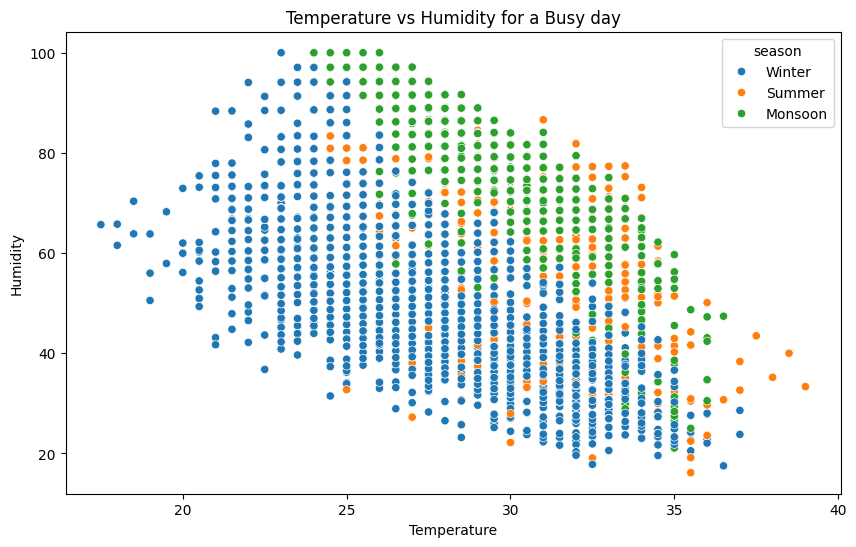

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-12-b8258723734b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = y_kmeans


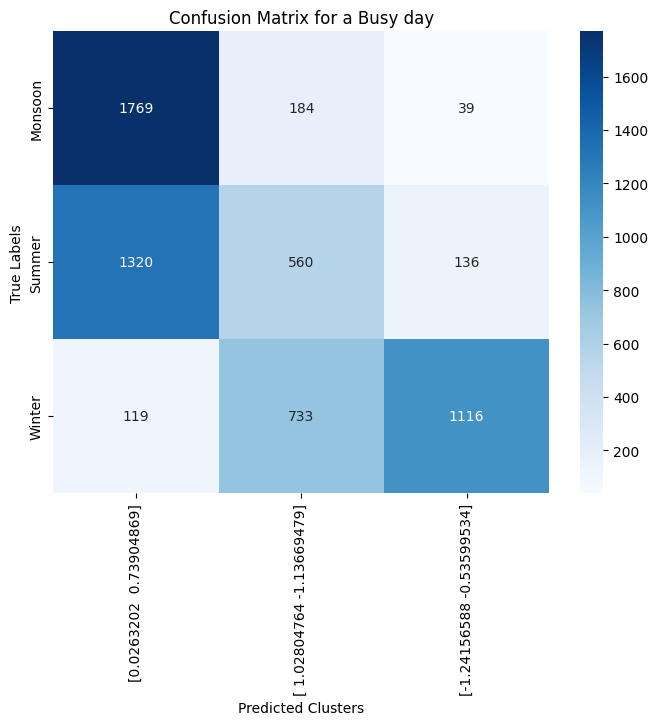

              precision    recall  f1-score   support

           0       0.55      0.89      0.68      1992
           1       0.38      0.28      0.32      2016
           2       0.86      0.57      0.68      1968

    accuracy                           0.58      5976
   macro avg       0.60      0.58      0.56      5976
weighted avg       0.60      0.58      0.56      5976

Inertia: 4367.230224513364
Silhouette Score: 0.45532074286776797


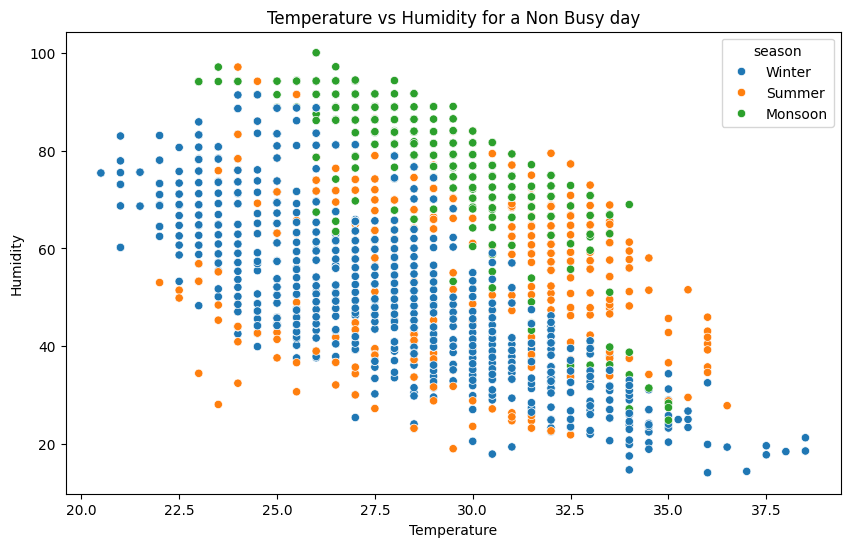

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-12-b8258723734b>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = y_kmeans


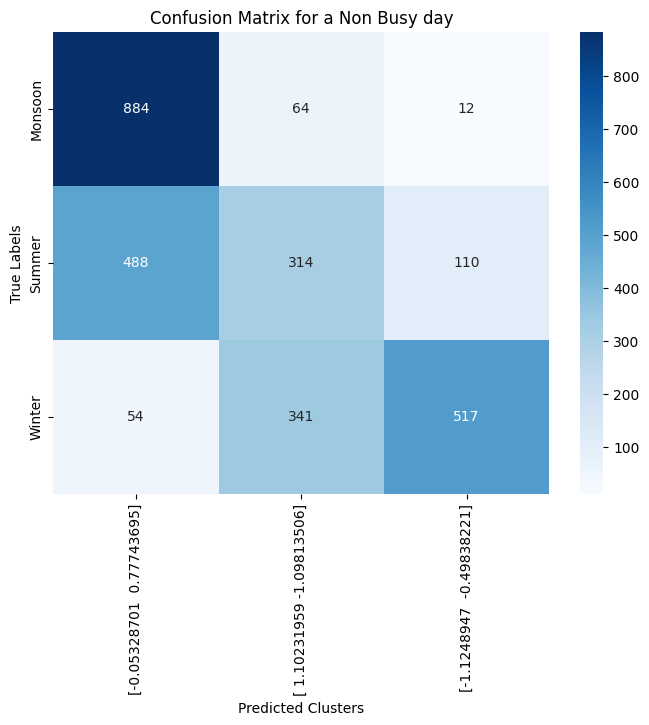

              precision    recall  f1-score   support

           0       0.62      0.92      0.74       960
           1       0.44      0.34      0.39       912
           2       0.81      0.57      0.67       912

    accuracy                           0.62      2784
   macro avg       0.62      0.61      0.60      2784
weighted avg       0.62      0.62      0.60      2784

Inertia: 1993.1499123475528
Silhouette Score: 0.4517264994282023


In [13]:
cluster_busy('Busy')
cluster_busy('Non Busy')

We can also do clustering on the data after splitting the data into days of the week. We just need to put a condition on the days of the week and run the same function with edits.

In [14]:
data.columns

Index(['Time', 'year', 'moy_date', 'doy_date', 'busday', 'season', 'dow_date',
       'hour', 'month_name', 'temp', 'humid', 'r1', 'r2', 'r3', 'r4', 'r5',
       'r6', 'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'Cluster'],
      dtype='object')

In [15]:
data['dow_date'].unique()

array([1, 2, 3, 4, 5, 6, 7])

In [16]:
df = data[['Time','dow_date', 'temp', 'humid', 'season']]

In [17]:
def cluster_dow(status):
  if status == 'Monday':
    data = df[df['dow_date'] == 1]
  elif status == 'Tuesday':
    data = df[df['dow_date'] == 0]
  # and so on

  #rest of the function